# Event-based Communication Example

This notebook illustrates how to simulate satellite to ground communication in PASEOS with a link budget model. 

First, let's import all necessary modules

In addition to PASEOS's requirements this notebook uses seaborn and pandas. `conda install seaborn` or `pip install seaborn` will get it. (analogously for pandas)

In [4]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sys
import asyncio
 
sys.path.append("..")
sys.path.append("../..")

import warnings
warnings.filterwarnings("ignore")

import pykep as pk
import numpy as np
import paseos
from paseos.actors.spacecraft_actor import SpacecraftActor
from paseos.actors.ground_station_actor import GroundstationActor
from paseos.communication.radio_link_model import RadioLinkModel
from paseos.actors.actor_builder import ActorBuilder
from paseos.utils.link_budget_calc import calc_dist_and_alt_angle
from paseos.communication.device_type import DeviceType
# paseos.set_log_level("WARNING") # use info / debug if you want more insight


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constellation setup

In addition to the code in this notebook, we use a simple function that automatically computes the orbits of a [Walker Constellation](https://en.wikipedia.org/wiki/Satellite_constellation#Walker_Constellation) for us. It allows us to only specify a few parameters to get started.

For illustrative purposes our constellation will consist of 1 satellite in LEO and one ground station at Maspalamos.

In [5]:
from utils.get_constellation import get_constellation
altitude = 550 * 1000 # constellation altitude above the Earth's ground [m]
inclination = 10.0 # inclination of each orbital plane
nPlanes = 1 # the number of orbital planes (see linked wiki article)
nSats = 1 # the number of satellites per orbital plane
t0 = pk.epoch_from_string("2023-Jan-05 02:00:00") # the starting date of our simulation

maspalomas_groundstation = ActorBuilder.get_actor_scaffold(
        name="maspalomas_groundstation", actor_type=GroundstationActor, epoch=t0
    )
ActorBuilder.set_ground_station_location(maspalomas_groundstation,latitude=27.7629, longitude=-15.6338, elevation=205.1, minimum_altitude_angle=5)

# Compute orbits of LEO satellites
planet_list,sats_pos_and_v,orbital_period = get_constellation(altitude,inclination,nSats,nPlanes,t0)

# This line to ensure the satellite is in line of sight with the ground station during simulation.
sats_pos_and_v[0] = [[  373533.80545186, -6910598.7742078 ,    65864.08810787], [7462.47263817,  415.90492902, 1315.83526891]]

Created 1 satellites...
Computing constellation's positions and velocities...
Done!


The ground station needs a receiver to receive the radio signal.

In [6]:
receiver_name = "maspalomas_radio_receiver_1"
ActorBuilder.add_comm_device(actor=maspalomas_groundstation, device_name=receiver_name, noise_temperature=135, 
                             line_losses=1, polarization_losses=3, antenna_gain=62.6, device_type=DeviceType.RADIO_RECEIVER)

Let's briefly plot our satellite orbits for illustrative purposes. We use [pykep's plotting features](https://esa.github.io/pykep/documentation/orbitplots.html) for that.

Note that angles aren't to scale in pykep plots.

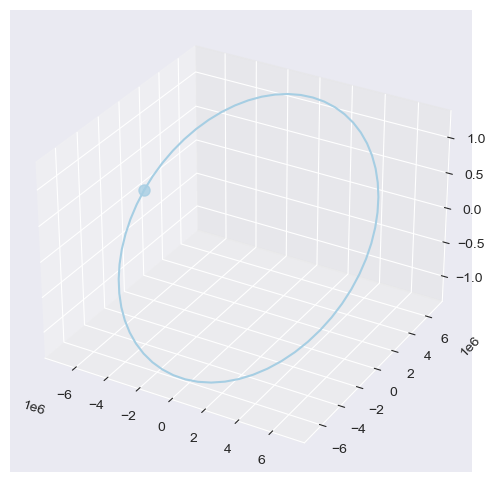

In [7]:
fig = plt.figure(figsize=(6,6),dpi=100)
ax = plt.axes(projection='3d')
colors = sns.color_palette("Paired")
for i in range (nPlanes*nSats):
    color_idx = i // nPlanes
    pk.orbit_plots.plot_planet(planet_list[i],axes=ax,s=64,color=colors[color_idx])

### PASEOS Setup

Now we will create a PASEOS instance for the LEO satellite. Further, we add a communication device, power device and a thermal model.

Pleae have a look at the [readme sections on physical models](https://github.com/aidotse/PASEOS#physical-models) for additional details.

In [9]:
paseos_instances = [] # this will store paseos instances
earth = pk.planet.jpl_lp("earth") # define our central body

for idx,sat_pos_v in enumerate(sats_pos_and_v):
    pos,v = sat_pos_v
    sat_actor:SpacecraftActor = ActorBuilder.get_actor_scaffold(name="Sat_"+str(idx),
                                                actor_type=SpacecraftActor,
                                                epoch=t0)
    ActorBuilder.set_orbit(actor=sat_actor,position=pos,velocity=v,epoch=t0,central_body=earth)
    radio_name = "sat_radio_transmitter_1"
    ActorBuilder.add_comm_device(actor=sat_actor,device_name=radio_name, input_power=2, power_efficiency=0.5,
                                antenna_efficiency=0.5, line_losses=1, point_losses=5, antenna_diameter=0.3, device_type=DeviceType.RADIO_TRANSMITTER)

    ActorBuilder.set_power_devices(actor=sat_actor,battery_level_in_Ws=10000+np.random.rand()*90000,
                                   max_battery_level_in_Ws=100000,charging_rate_in_W=50)
    ActorBuilder.set_thermal_model(
            actor=sat_actor,
            actor_mass=50.0,
            actor_initial_temperature_in_K=273.15,
            actor_sun_absorptance=1.0,
            actor_infrared_absorptance=1.0,
            actor_sun_facing_area=2.0,
            actor_central_body_facing_area=2.0,
            actor_emissive_area=4.0,
            actor_thermal_capacity=1000
    )

    frequency = 8475E6 #Hz
    radio_link = RadioLinkModel(transmitter_actor=sat_actor, transmitter_device_name=radio_name, 
                                receiver_actor=maspalomas_groundstation, receiver_device_name=receiver_name, frequency=frequency)
    instance = paseos.init_sim(local_actor=sat_actor, communication_links=[radio_link])
    paseos_instances.append(instance)

We can use PASEOS internal plotting to have a look at our setup now.

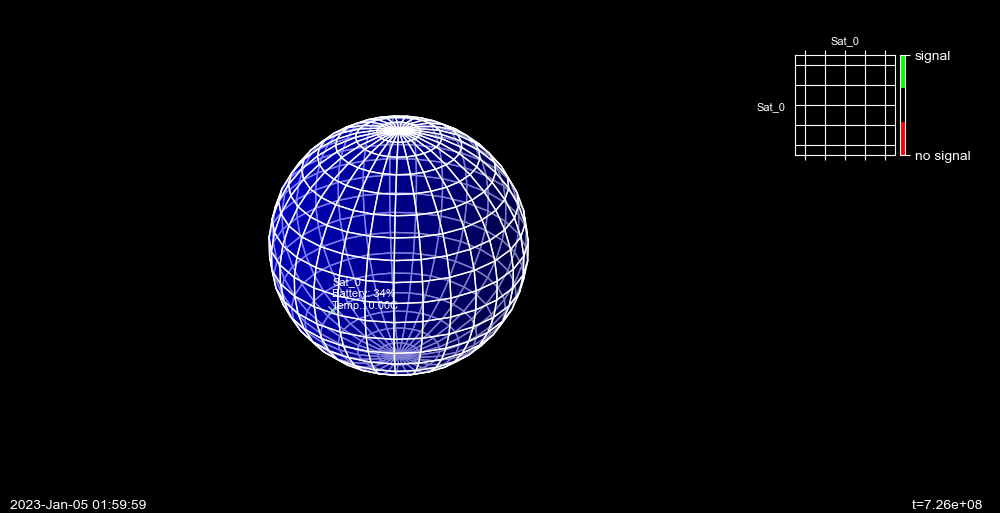

In [10]:
paseos_instances[0].empty_known_actors()
for instance in paseos_instances[1:]:
    paseos_instances[0].add_known_actor(instance.local_actor)
plotter = paseos.plot(paseos_instances[0], paseos.PlotType.SpacePlot)

Now, we define some operational constraints for our constellation. Let's say our LEO satellites have two tasks:

* Processing - Consumes 100W and can only be performed at < 56.85° C and if our battery is at least 20% charged.
* Standby - What we do if the above constraint is violated (costs 2W)

To this end, we define a function that returns `True` if the constraint is met.

In [11]:
def get_consumption_and_activity(actor):
    """Determine power consumption and activity for an actor."""
    if operational_constraint(actor):
        value = 100
        action = "Processing"
        transmitters = actor.get_all_transmitters()
        for transmitterName in transmitters:
            transmitter = actor.get_transmitter(transmitterName)
            if transmitter.active:
                value += transmitter.input_power
                action += "Communicating"

        # Power consumption for processing is 100W
        return value,action
    else: 
        # Power consumption in standby is 2W
        return 2.0, "Standby"

def operational_constraint(actor):
    """Determine if constraint is met for an actor"""
    if (actor.state_of_charge > 0.2 
        and actor.temperature_in_K < 330):
        return True
    else:
        return False

### Running the simulation

Now, we are ready to run the main simulation. We will simulate the operations of this constellation for 8 hours. Every 600 seconds (or once the constraint is no longer valid) we will redecide whether a satellite is going to "charge" or "process".

Whenever a satellite starts violating the operational constraint, it will stop the activity and continue to standby. This is marked by an `INFO` output from PASEOS.

If the activity is interrupted due to overheating or lack of battery charge, we continue charging in standby for the remaining time of the 600 second window.

In [13]:
simulation_time = 24.0 * 3600 # eight hours in seconds
t = 0 # starting time in seconds
timestep = 1200 # how often we decide what each sat should do [s]

# Run until end of simulation
while t <= simulation_time: 
    N_standby = 0 # track in standby
    N_processing = 0 # track processors
    N_interruped = 0 # track which switched due to constraint
    # For each satellite, we perform the following steps
    for instance in paseos_instances:
        local_t = instance.local_actor.local_time
        # Update known actors, i.e. for each sat if they can
        # see the ground station and the comms satellite
        for link in instance.communication_links:
            distance, elevation_angle = calc_dist_and_alt_angle(instance.local_actor, link.receiver_actor, local_t)
            if instance.local_actor.is_in_line_of_sight(link.receiver_actor, epoch=local_t):
                link.set_line_of_sight(True)
                bitrate = link.get_bitrate(distance, elevation_angle)
                link.set_bitrate(bitrate)
            else:
                link.set_bitrate(0)
                link.set_line_of_sight(False)
            link.set_distance(distance)
            link.set_elevation_angle(elevation_angle)
                
        instance.empty_known_actors()

        # Determine whether satellite is processing or in standby
        power_consumption, activity = get_consumption_and_activity(instance.local_actor)
        if "Processing" in activity:
            N_processing += 1
            eval_constraint = lambda: operational_constraint(instance.local_actor)
        else:
            N_standby += 1
            eval_constraint = None
        
        # This call is only necessary to display running activity 
        # in PASEOS internal monitoring (which we use below)
        instance.local_actor._current_activity = activity

        # Advance the simulation state of this satellite
        # Note how we pass the "eval_constraint" to tell paseos to evaluate if the constraint
        # for running the "Processing" is still satisfied
        time_remaining_to_advance = instance.advance_time(
            time_to_advance=timestep,
            current_power_consumption_in_W=power_consumption,
            constraint_function=eval_constraint
        )

        # If activity was interrupted by constraint violation, proceed in standby for remainder
        if time_remaining_to_advance > 0:
            N_interruped += 1
            instance.advance_time(
            time_to_advance=time_remaining_to_advance,
            current_power_consumption_in_W=2.0,
            constraint_function=None
        )
            
    print(f"Time: {t}s - # of Processing = {N_processing} ({N_interruped} interrupted), # of Standby = {N_standby}")
    t += timestep

Time: 0s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 1200s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 2400s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 3600s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 4800s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 6000s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 7200s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 8400s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 9600s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 10800s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 12000s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 13200s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 14400s - # of Processing = 1 (1 interrupted), # of Standby = 0
Time: 15600s - # of Processing = 0 (0 interrupted), # of Standby = 1
Time: 16800s - # of Processing = 1 (1 interrup

### Plotting and Analysis

Alright! Now, let's have a look at what actually happened during our simulation.

For this, we will make use of [PASEOS' monitor](https://github.com/aidotse/PASEOS#monitor).

The below code uses it to extract a few quantities for all our sats and plots them over the course of the simulation for each satellite (each color is one).

This will give us a good impression of whether each satellite's operations are sensible.

We will also accumulate all the data into a [pandas dataframe](https://pandas.pydata.org/docs/user_guide/10min.html) for convenience.

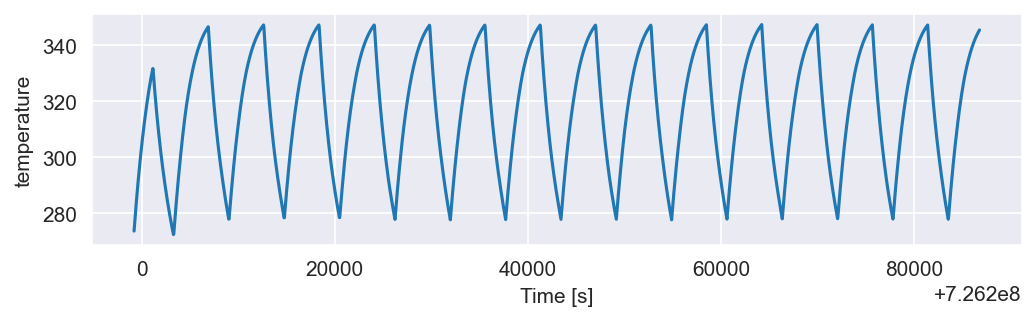

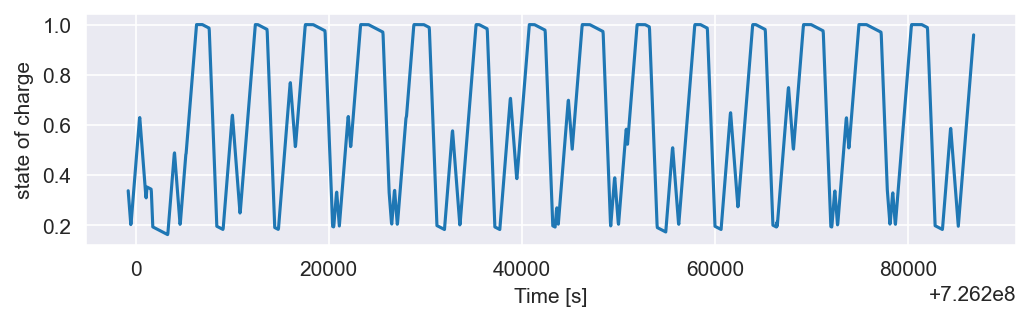

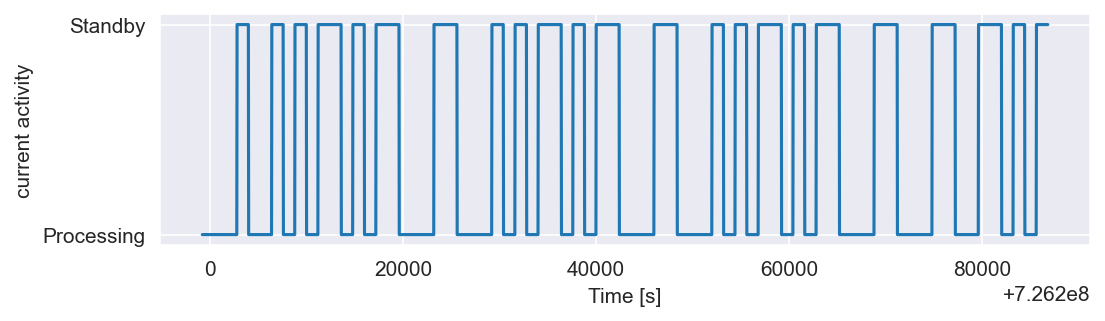

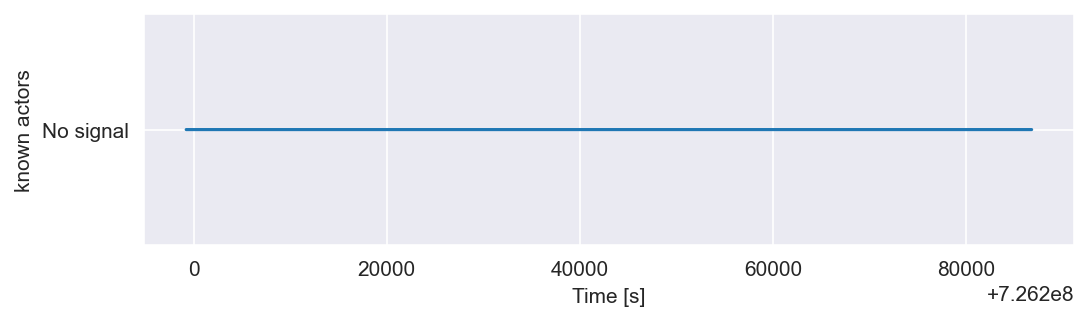

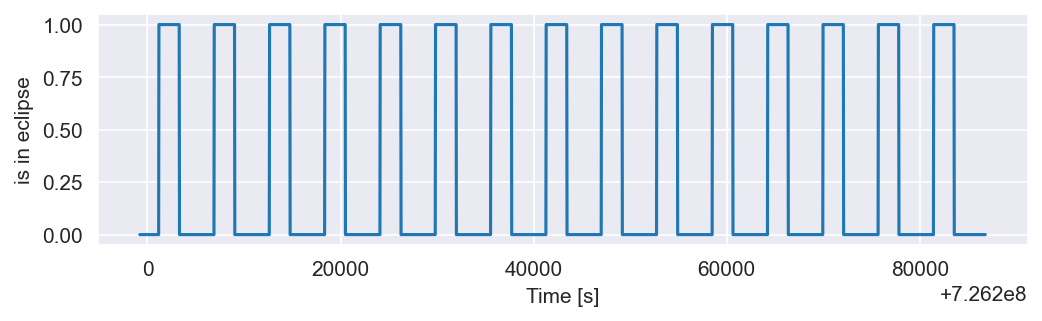

<Figure size 1200x300 with 0 Axes>

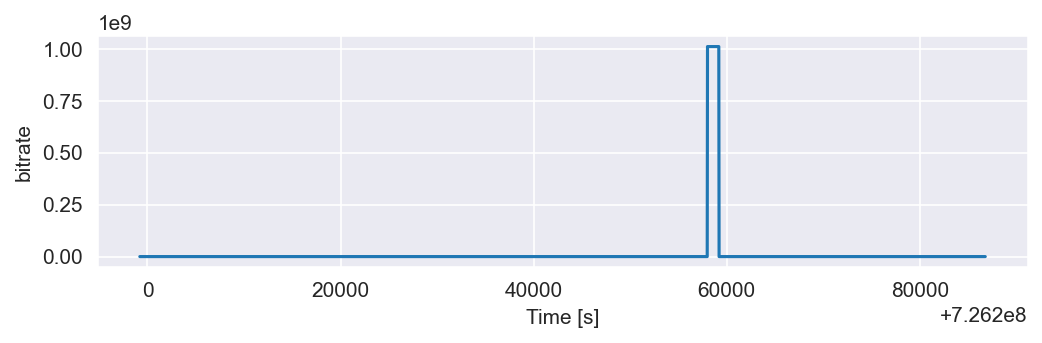

<Figure size 1200x300 with 0 Axes>

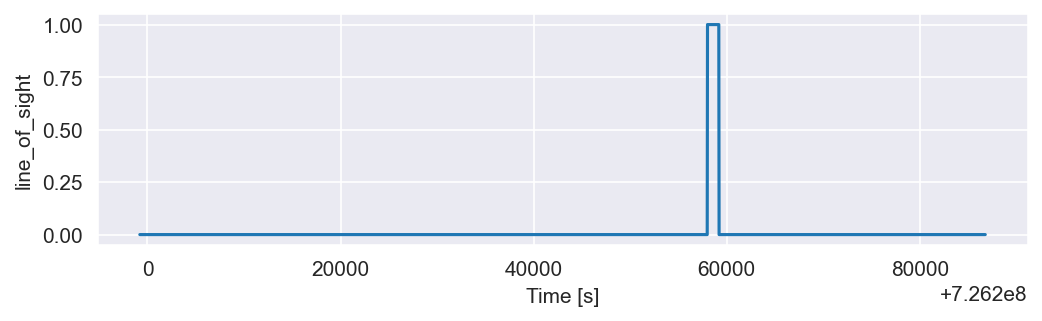

<Figure size 1200x300 with 0 Axes>

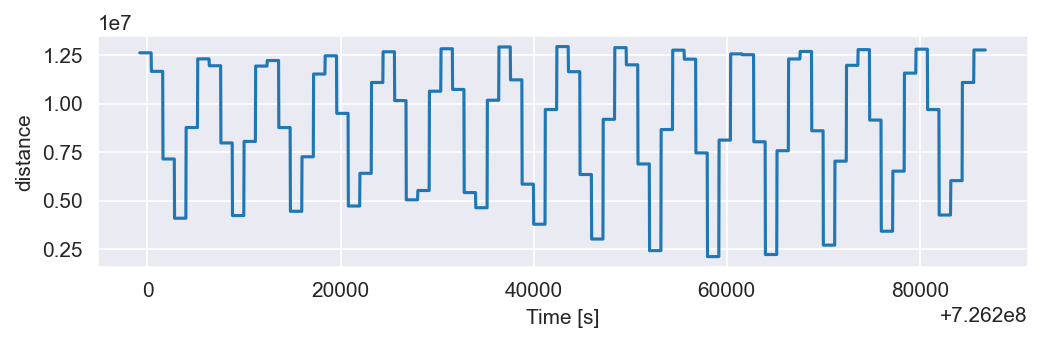

<Figure size 1200x300 with 0 Axes>

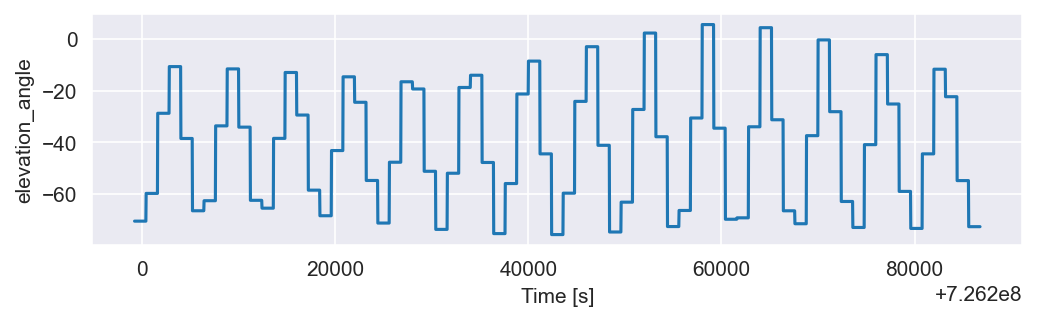

In [14]:
from communication_example_utils import get_known_actor_comms_status, get_bitrate_status, get_line_of_sight_status, get_distance_status, get_elevation_angle_status

# Quantities we want to track
quantities = ["temperature","state_of_charge","current_activity","known_actors","is_in_eclipse", "bitrate", "line_of_sight", "distance", "elevation_angle"]

# Setup data frame to collect all data
df = pd.DataFrame(columns=("Time","ID"))
for idx,item in enumerate(quantities):
    names = []

    # Dataframe for this quantity
    small_df = pd.DataFrame(columns=("Time","ID"))
    
    plt.figure(figsize=(8, 2),dpi=150)

    # Get data from all satellites and plot it
    for instance in paseos_instances:

        # Get time of each data point
        timesteps = instance.monitor["timesteps"]

        # Get data
        communication_histories = []

        if item == "known_actors":
            values = get_known_actor_comms_status(instance.monitor[item])
        elif item == "bitrate":
            for link in instance.communication_links:
                communication_histories.append(get_bitrate_status(link))
        elif item == "line_of_sight":
            for link in instance.communication_links:
                communication_histories.append(get_line_of_sight_status(link))
        elif item == "distance":
            for link in instance.communication_links:
                communication_histories.append(get_distance_status(link))
        elif item == "elevation_angle":
            for link in instance.communication_links:
                communication_histories.append(get_elevation_angle_status(link))
        else:
            values = instance.monitor[item]
        names.append(instance.local_actor.name)

        if item == "bitrate" or item == "line_of_sight" or item == "distance" or item == "elevation_angle":
            # Collect data from this sat into big dataframe
            for history in communication_histories:
                plt.figure(figsize=(8, 2),dpi=150)
                smaller_df = pd.DataFrame({"Time": timesteps,"ID": len(timesteps)*[instance.local_actor.name],item: history})
                small_df = pd.concat([small_df,smaller_df])
                if item == "line_of_sight":
                    smaller_df[item] = smaller_df[item].astype("boolean")
                plt.plot(timesteps,history)
                plt.xlabel("Time [s]")
                plt.ylabel(item)
        else:
            smaller_df = pd.DataFrame({"Time": timesteps,"ID": len(timesteps)*[instance.local_actor.name],item: values})
            if item == "is_in_eclipse": #pandas things...
                smaller_df["is_in_eclipse"] = smaller_df["is_in_eclipse"].astype("boolean")
            small_df = pd.concat([small_df,smaller_df])
        
            # Plot it :)
            plt.plot(timesteps,values)
            plt.xlabel("Time [s]")
            plt.ylabel(item.replace("_", " "))

    # Add a legend showing which satellite is which
    # plt.legend(
    #         names,
    #         fontsize = 8,
    #         bbox_to_anchor=(0.5, 1.4),
    #         ncol=10,
    #         loc="upper center",
    # )
    
    df = df.merge(small_df,how="right")